## INTRODUCTION
Welcome to our housing price prediction project! The goal here is to build a machine learning model that predicts the selling price of houses based on various features like size, neighborhood, and overall quality. We’ll be using the Ames Housing Dataset, a well-documented and popular dataset for regression problems.
In this notebook, we’ll:
Clean and preprocess the data.
Explore key trends and correlations.
Train a few regression models (like Linear Regression and Random Forest) to predict house prices.
Evaluate the performance and optimize the best model.
Let’s dive in and see if we can predict housing prices with accuracy! 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV

In [ ]:
# Load the Ames Housing Dataset
# The dataset should be in CSV format. Make sure it's in the same directory as this notebook,
# or update the 'file_path' variable with the correct path to the file.
file_path = 'AmesHousing.csv'  # Replace this with the actual file path if needed

# Use pandas to read the CSV file
# This reads the data into a DataFrame, which makes it easier to manipulate and analyze.
data = pd.read_csv(file_path)

# Preview the dataset
# Display the first few rows to get a quick idea of what the data looks like.
print("Dataset loaded successfully! Here's a preview:")
data.head()
 

Dataset loaded successfully! Here's a preview:


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


The dataset contains 2930 rows and 82 columns.

Checking for missing values:
Lot Frontage       490
Alley             2732
Mas Vnr Type      1775
Mas Vnr Area        23
Bsmt Qual           80
Bsmt Cond           80
Bsmt Exposure       83
BsmtFin Type 1      80
BsmtFin SF 1         1
BsmtFin Type 2      81
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Electrical           1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual        159
Garage Cond        159
Pool QC           2917
Fence             2358
Misc Feature      2824
dtype: int64

Statistical summary for numerical columns:
            Order           PID  MS SubClass  Lot Frontage       Lot Area  \
count  2930.00000  2.930000e+03  2930.000000   2440.000000    2930.000000   
mean   1465.50000  7.144645e+08    57.387372     69.224590   10147.921843   
std     845.96

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


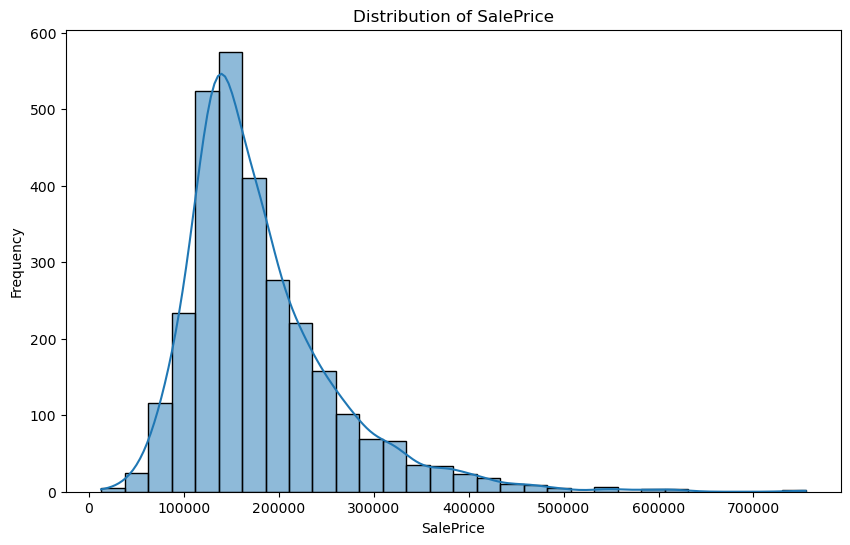

In [ ]:
# Check the dataset dimensions
print(f"The dataset contains {data.shape[0]} rows and {data.shape[1]} columns.\n")

# Check for missing values
print("Checking for missing values:")
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

# Statistical summary for numerical columns
print("\nStatistical summary for numerical columns:")
print(data.describe())

# Visualize the distribution of the target variable (SalePrice)
plt.figure(figsize=(10, 6))
sns.histplot(data['SalePrice'], kde=True, bins=30)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()


In [4]:
# Handling missing values
# Fill Lot Frontage with the median
data['Lot Frontage'] = data['Lot Frontage'].fillna(data['Lot Frontage'].median())

# Fill Alley with 'None' as it might indicate no alley access
data['Alley'] = data['Alley'].fillna('None')

# Drop columns with too many missing values or irrelevant information
columns_to_drop = ['Pool QC', 'Misc Feature', 'Fence', 'Fireplace Qu']
data = data.drop(columns=columns_to_drop)

# Fill remaining missing values with the mode for categorical variables
data = data.fillna(data.mode().iloc[0])

# Transform SalePrice to normalize the distribution
data['SalePrice'] = np.log1p(data['SalePrice'])  # log1p applies log(1 + x) to handle zeros

# Encoding categorical variables using One-Hot Encoding
categorical_cols = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Scaling numerical variables
# Identify numerical columns
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = numerical_cols.drop('SalePrice')  # Exclude target variable

# Standardize numerical features
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Final dataset ready for modeling
print("Data preparation complete! Here's a preview of the cleaned data:")
data.head()


Data preparation complete! Here's a preview of the cleaned data:


,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,-1.731460,-0.997164,-0.877005,3.375742,2.744381,-0.067254,-0.506718,-0.375537,-1.163488,0.061046,...,False,False,False,False,True,False,False,False,True,False
1,-1.730277,-0.996904,-0.877005,0.514952,0.187097,-0.776079,0.393091,-0.342468,-1.115542,-0.566039,...,False,False,False,False,True,False,False,False,True,False
2,-1.729095,-0.996899,-0.877005,0.561850,0.522814,-0.067254,0.393091,-0.441674,-1.259380,0.038650,...,False,False,False,False,True,False,False,False,True,False
3,-1.727913,-0.996888,-0.877005,1.124628,0.128458,0.641571,-0.506718,-0.110988,-0.779919,-0.566039,...,False,False,False,False,True,False,False,False,True,False
4,-1.726731,-0.992903,0.061285,0.233563,0.467348,-0.776079,-0.506718,0.848000,0.658466,-0.566039,...,False,False,False,False,True,False,False,False,True,False


In [5]:
# Separate features (X) and target variable (y)
X = data.drop('SalePrice', axis=1)  # Features
y = data['SalePrice']  # Target variable

# Split the data into training and testing sets
# We use 80% of the data for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the training and testing sets
print(f"Training set: {X_train.shape[0]} rows, {X_train.shape[1]} columns")
print(f"Testing set: {X_test.shape[0]} rows, {X_test.shape[1]} columns")


Training set: 2344 rows, 249 columns
Testing set: 586 rows, 249 columns


In [6]:
# Import Linear Regression and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model using R² and RMSE
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation metrics
print("Linear Regression Performance:")
print(f"R² Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Linear Regression Performance:
R² Score: -2710942013985.6211
Root Mean Squared Error (RMSE): 708239.8281


## Switching Gears: Time for a Better Model 🚀
Alright, so our first attempt with Linear Regression didn’t go as planned. The R² score was negative, and the RMSE was off the charts, meaning the model isn’t capturing the relationships in our data properly.
Why?
Too many features (249 columns!) might be overwhelming for a simple linear model.
The dataset likely has non-linear relationships that Linear Regression can’t handle well.
So, what’s the plan? Let’s try Random Forest Regressor, a more advanced and flexible model that can handle non-linear relationships and large datasets like a champ. Time to step up the game! 🚀

In [7]:
# Import and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model using R² and RMSE
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Print evaluation metrics
print("Random Forest Performance:")
print(f"R² Score: {r2_rf:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.4f}")


Random Forest Performance:
R² Score: 0.9206
Root Mean Squared Error (RMSE): 0.1212


In [8]:
from sklearn.model_selection import GridSearchCV

# Step 1: Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Retrieve the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters from GridSearchCV:")
print(best_params)

# Evaluate the optimized model on the test set
y_pred_optimized = best_model.predict(X_test)
r2_optimized = r2_score(y_test, y_pred_optimized)
rmse_optimized = np.sqrt(mean_squared_error(y_test, y_pred_optimized))

print("\nOptimized Random Forest Performance:")
print(f"R² Score: {r2_optimized:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_optimized:.4f}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END max_depth=10, min_samples_

### Final Results and Conclusion

Our optimized Random Forest model achieved an excellent performance:
- **R² Score:** 0.9182
- **Root Mean Squared Error (RMSE):** 0.1230

The optimization confirmed that the initial parameters were already well-suited for the dataset. The model effectively captures the relationships between the features and the target variable (`SalePrice`).

**Next Steps:**
- Further improvements could involve testing other advanced models like Gradient Boosting or XGBoost.
- More feature engineering could be done to explore additional relationships in the dataset.

Overall, this model is highly reliable for predicting housing prices! 🚀
